In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [3]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

--2025-11-04 13:19:15--  https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip?raw=true
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fisher85/ml-cybersecurity/raw/refs/heads/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip [following]
--2025-11-04 13:19:16--  https://github.com/fisher85/ml-cybersecurity/raw/refs/heads/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fisher85/ml-cybersecurity/refs/heads/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_IS

In [4]:
df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', engine='python', encoding='latin-1')

In [5]:
df.shape

(458968, 85)

In [6]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape


(458968, 84)

In [7]:
df['Label'].unique()

array(['BENIGN', 'Web Attack \x96 Brute Force', 'Web Attack \x96 XSS',
       'Web Attack \x96 Sql Injection', nan], dtype=object)

In [8]:
df['Label'].value_counts()

,count
Label,
BENIGN,168186
Web Attack  Brute Force,1507
Web Attack  XSS,652
Web Attack  Sql Injection,21


In [9]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

In [10]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

In [11]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

In [12]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [13]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

In [14]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

168186

In [15]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

2180

In [16]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

,count
Label,
BENIGN,168186
Web Attack  Brute Force,1507
Web Attack  XSS,652
Web Attack  Sql Injection,21


In [17]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

5086.666666666667 0.03326872232726466


In [18]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]

In [19]:
df_balanced['Label'].value_counts()

,count
Label,
BENIGN,5087
Web Attack  Brute Force,1507
Web Attack  XSS,652
Web Attack  Sql Injection,21


In [20]:
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Brute Force"]
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Sql Injection"]
# df_balanced['Label'].value_counts()

In [21]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

In [22]:
df = pd.read_csv('web_attacks_balanced.csv')

In [23]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [24]:
#!wget https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/mix_labelled.zip -O mix_labelled.zip
#!unzip -u mix_labelled.zip

In [25]:
#df = pd.read_csv('mix_labelled.csv')
#excluded = ['Flow Key', 'Flow Bytes/s', 'Flow MB/s', 'Fwd IAT Min',
#            'Flow IAT Min', 'Packet Length Mean', 'Average Fwd Segment Size', 'Subflow Fwd Bytes',
#            'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Mean',
#            'Average Bwd Segment Size', 'Bwd Packet Length Mean', 'Packet Length List', 'Total Fwd Packets',
#            'Packet Length Std', 'Packet Length Variance', 'Total Backword Packets', 'Fwd Packet Length Std',
#            'Total Length of Bwd Packets', 'Bwd Header Length']
#df = df.drop(columns=excluded, errors='ignore')

In [26]:
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded, errors='ignore')

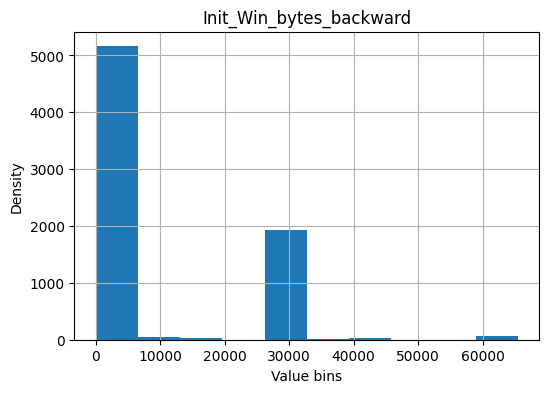

In [27]:
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

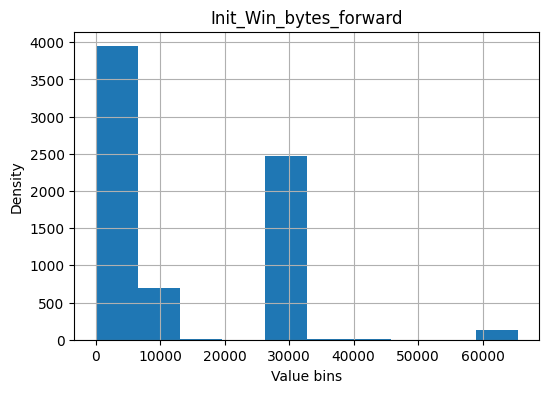

In [28]:
if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [29]:
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2, errors='ignore')

In [30]:
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(7267, 74) (7267,)


# Feature

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{np.int64(0): np.int64(3557), np.int64(1): np.int64(1529)}

### Visualization of the decision tree, importance evaluation using a single tree (DecisionTreeClassifier)

In the beginning we use one tree - for the convenience of visualization of the classifier. High cross-validation scores even with 5 leaves look suspiciously good, we should look at the data carefully. Parameters for change - test_size in the cell above (train_test_split), max_leaf_nodes in the cell below.

By changing the **random_state** parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.96267191, 0.97249509, 0.956778  , 0.96267191, 0.9410609 ,
       0.96463654, 0.96259843, 0.96850394, 0.9488189 , 0.9507874 ])

In [33]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Packet Length Mean <= 0.57
|   |--- Fwd Header Length <= 100.00
|   |   |--- Bwd Packets/s <= 8889.06
|   |   |   |--- class: 0
|   |   |--- Bwd Packets/s >  8889.06
|   |   |   |--- class: 1
|   |--- Fwd Header Length >  100.00
|   |   |--- class: 1
|--- Packet Length Mean >  0.57
|   |--- Subflow Fwd Bytes <= 30888.00
|   |   |--- class: 0
|   |--- Subflow Fwd Bytes >  30888.00
|   |   |--- class: 1



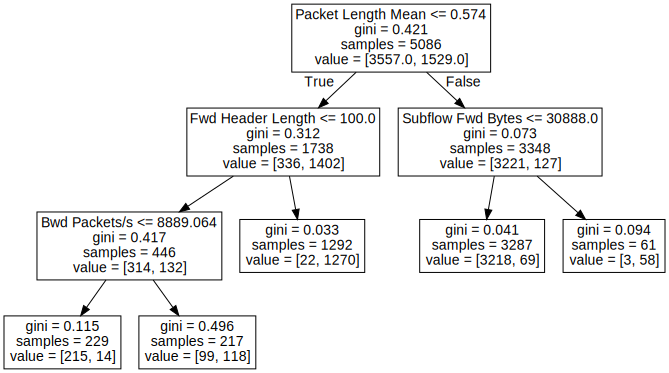

In [34]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns))

In [35]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{np.int64(0): np.int64(1530), np.int64(1): np.int64(651)}

In [36]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1470,   60],
       [  36,  615]])

### Importance evaluation using SelectFromModel (still one decision tree)

Source: https://github.com/oreilly-mlsec/book-resources/blob/master/chapter2/select-from-model-nslkdd.ipynb

In [37]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.17189853, 0.        ,
       0.        , 0.02851111, 0.        , 0.        , 0.74271159,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05687877, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [38]:
sfm.threshold_

np.float64(0.013513513513513514)

In [39]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 4


In [40]:
indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Packet Length Mean - 0.7427115868768307
1.	Fwd Header Length - 0.1718985335577824
2.	Subflow Fwd Bytes - 0.056878769574672486
3.	Bwd Packets/s - 0.028511109990714458
4.	Active Min - 0.0
5.	Active Max - 0.0
6.	Idle Std - 0.0
7.	Idle Mean - 0.0
8.	Idle Min - 0.0
9.	Idle Max - 0.0


In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 0.99 
R^2 Validation Score: 0.98 
Out-of-bag Score: 0.98


In [42]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices[:20]):
    webattack_features.append(features[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#13	0.083	Flow Bytes/s
2.	#51	0.081	Average Packet Size
3.	#38	0.065	Max Packet Length
4.	#39	0.063	Packet Length Mean
5.	#7	0.058	Fwd Packet Length Mean
6.	#61	0.056	Subflow Fwd Bytes
7.	#23	0.049	Fwd IAT Min
8.	#52	0.046	Avg Fwd Segment Size
9.	#3	0.045	Total Length of Fwd Packets
10.	#5	0.032	Fwd Packet Length Max
11.	#21	0.031	Fwd IAT Std
12.	#33	0.029	Fwd Header Length
13.	#15	0.028	Flow IAT Mean
14.	#16	0.023	Flow IAT Std
15.	#0	0.022	Flow Duration
16.	#14	0.021	Flow Packets/s
17.	#35	0.021	Fwd Packets/s
18.	#20	0.017	Fwd IAT Mean
19.	#34	0.017	Bwd Header Length
20.	#22	0.015	Fwd IAT Max


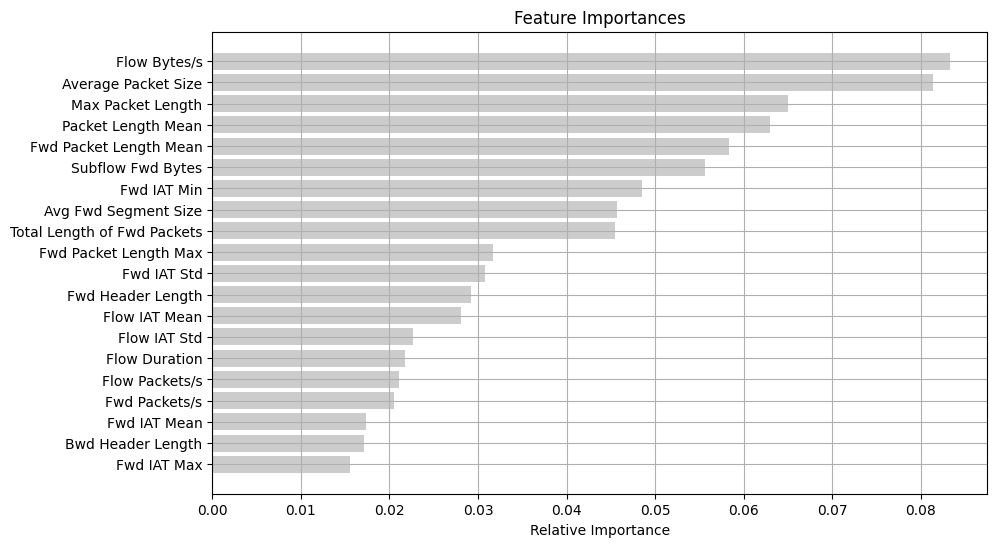

In [43]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1509,   21],
       [  20,  631]])

In [45]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Flow Bytes/s',
 'Average Packet Size',
 'Max Packet Length',
 'Packet Length Mean',
 'Fwd Packet Length Mean',
 'Subflow Fwd Bytes',
 'Fwd IAT Min',
 'Avg Fwd Segment Size',
 'Total Length of Fwd Packets',
 'Fwd Packet Length Max',
 'Fwd IAT Std',
 'Fwd Header Length',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow Duration',
 'Flow Packets/s',
 'Fwd Packets/s',
 'Fwd IAT Mean',
 'Bwd Header Length',
 'Fwd IAT Max']

## Analysis of selected features

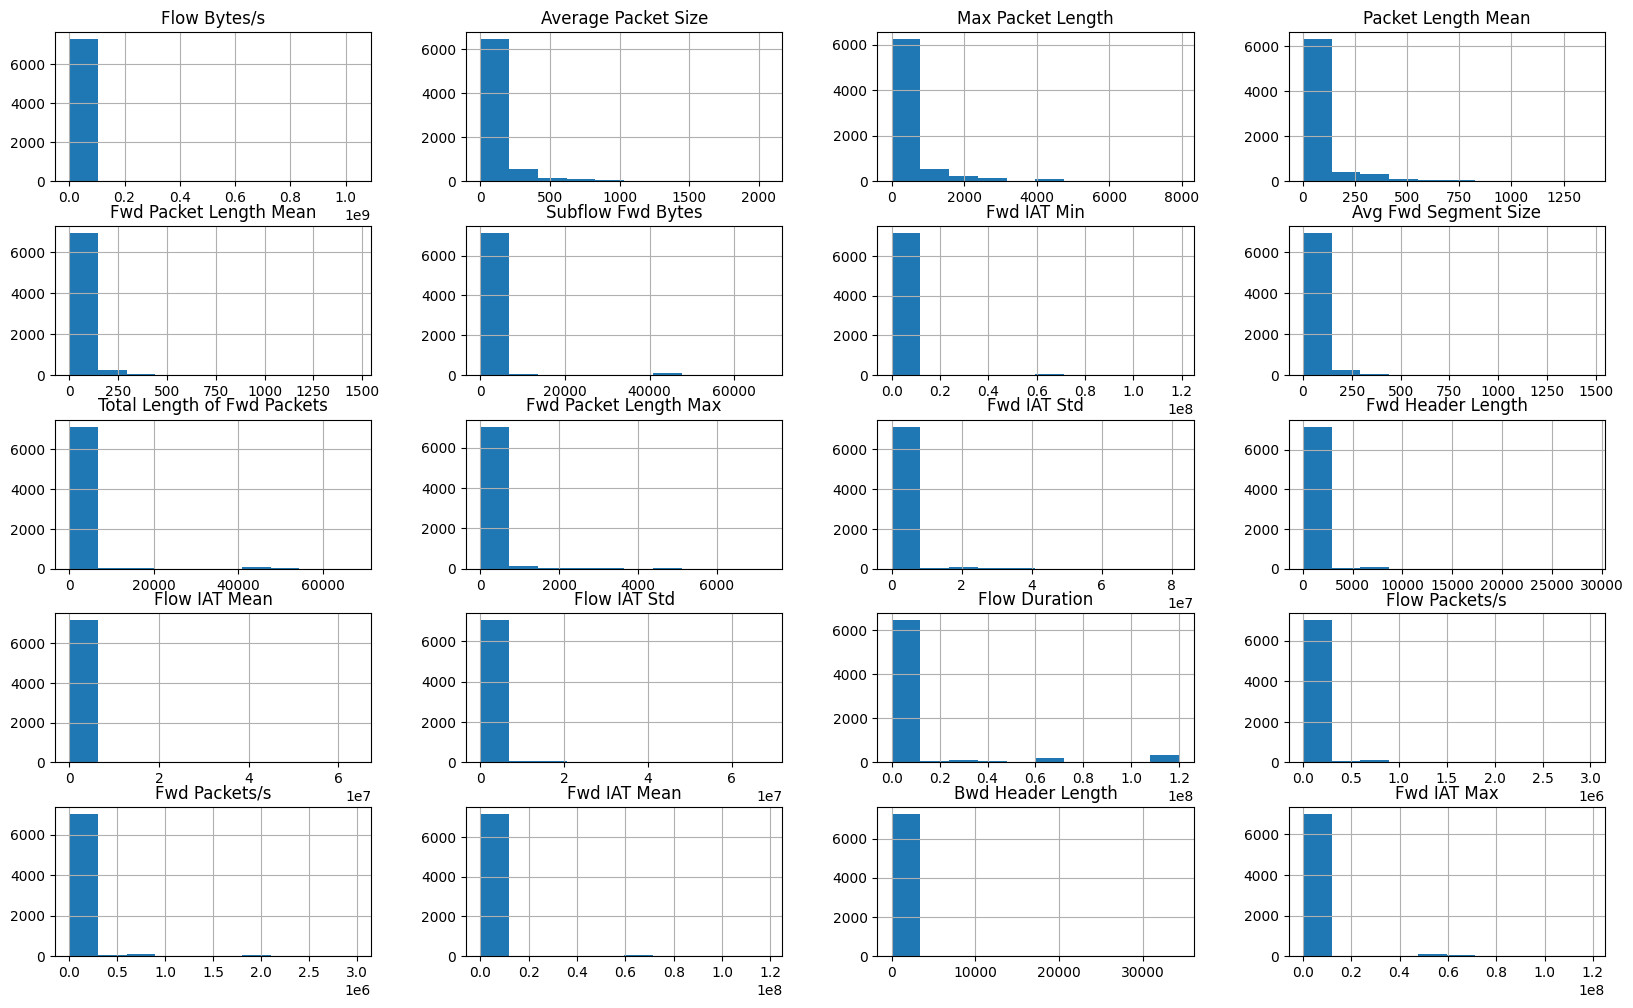

In [46]:
df[webattack_features].hist(figsize=(20,12), bins=10);
plt.savefig('features_hist.png', dpi=300)

In [47]:
!pip install facets-overview

### Create the feature stats for the datasets and stringify it.

In [49]:
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train + test', 'table': df[webattack_features]}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

/usr/local/lib/python3.12/dist-packages/facets_overview/base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Display the facets overview visualization for this data.

In [50]:
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

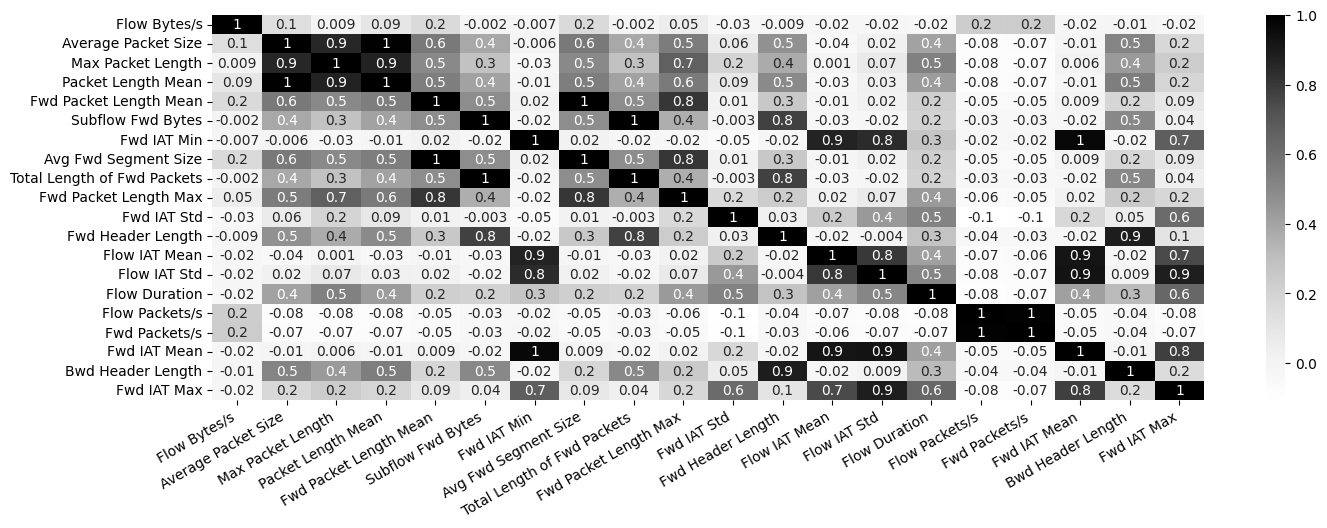

In [51]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

In [52]:
to_be_removed = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes',
                 'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:10]
webattack_features

['Flow Bytes/s',
 'Average Packet Size',
 'Max Packet Length',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Total Length of Fwd Packets',
 'Fwd Packet Length Max',
 'Fwd IAT Std',
 'Fwd Header Length',
 'Flow IAT Mean']

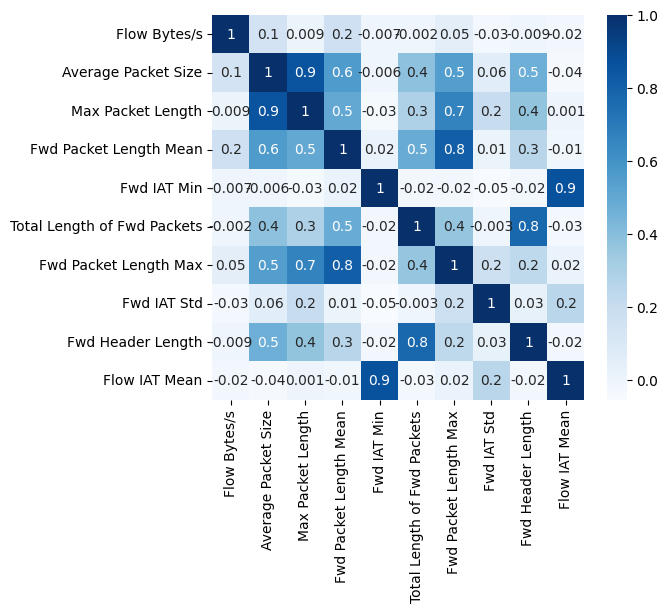

In [57]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Blues');

## Hyperparameter selection

In [58]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(7267, 10) (7267,)


In [59]:
#df = pd.read_csv('mix_labelled.csv')
#y = df['Label'].values
#X = df[webattack_features]
#print(X.shape, y.shape)

We get the list of RandomForestClassifier parameters.

In [60]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [62]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

ValueError: 'labels' must be of length 'x', not 20

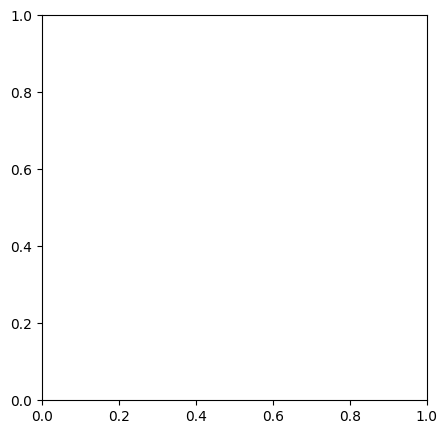

In [71]:
df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df[webattack_features]
plt.pie(df['Label'].value_counts(), labels=['BENIGN', 'ATTACK'])
plt.show()

In [ ]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_f1,...,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy
0,0.066604,0.009058,0.012801,0.002857,1,3,3,10,"{'max_depth': 1, 'max_features': 3, 'min_sampl...",0.853273,...,0.907645,0.907187,0.907645,0.906575,0.903976,0.904143,0.903532,0.906742,0.906151,0.001644
1,0.092505,0.015404,0.013001,0.001789,2,3,3,10,"{'max_depth': 2, 'max_features': 3, 'min_sampl...",0.896725,...,0.957187,0.956422,0.956269,0.956728,0.957492,0.952760,0.952760,0.957805,0.956195,0.001790
2,0.102306,0.010199,0.013101,0.001513,3,3,3,10,"{'max_depth': 3, 'max_features': 3, 'min_sampl...",0.896203,...,0.959939,0.959327,0.959021,0.958563,0.959327,0.954594,0.955359,0.959792,0.958549,0.001858
3,0.109006,0.017194,0.011901,0.001640,4,3,3,10,"{'max_depth': 4, 'max_features': 3, 'min_sampl...",0.907268,...,0.971101,0.970948,0.970948,0.971254,0.972018,0.969271,0.963920,0.973399,0.969956,0.002513
4,0.122207,0.012255,0.013101,0.002022,5,3,3,10,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.926108,...,0.974159,0.972018,0.972477,0.972324,0.972171,0.969424,0.969424,0.974010,0.972173,0.001564


NameError: name 'results' is not defined

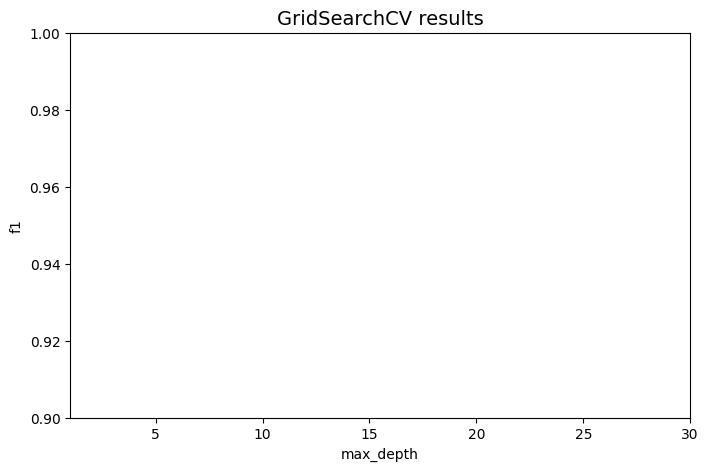

In [77]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html
plt.figure(figsize=(8, 5))
plt.title("GridSearchCV results", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("f1")

ax = plt.gca()
ax.set_xlim(1, 30)
ax.set_ylim(0.9, 1)

X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index] + 0.3, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV_results.png', dpi=300)
plt.show()

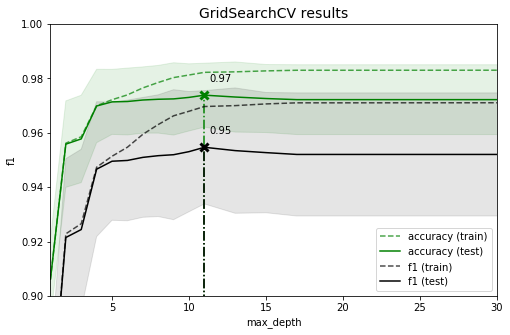

In [ ]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html
plt.figure(figsize=(8, 5))
plt.title("GridSearchCV results", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("f1")

ax = plt.gca()
ax.set_xlim(1, 30)
ax.set_ylim(0.9, 1)

X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index] + 0.3, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV_results.png', dpi=300)
plt.show()


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5086, 10) (5086,)
(2181, 10) (2181,)


In [80]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
# rfc = RandomForestClassifier(n_estimators=250, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [81]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for index, i in enumerate(indices[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#2	0.316	Max Packet Length
2.	#1	0.312	Average Packet Size
3.	#8	0.151	Fwd Header Length
4.	#9	0.056	Flow IAT Mean
5.	#5	0.051	Total Length of Fwd Packets
6.	#0	0.041	Flow Bytes/s
7.	#4	0.029	Fwd IAT Min
8.	#7	0.025	Fwd IAT Std
9.	#3	0.014	Fwd Packet Length Mean
10.	#6	0.004	Fwd Packet Length Max


In [82]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1511,   19],
       [  26,  625]])

In [83]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9793672627235214
Precision = 0.9704968944099379
Recall = 0.9600614439324117
F1 = 0.9652509652509652
